## Project Overview <a class='anchor' id='Section_1'>

Credit default risk is the risk that a lender takes the chance that a borrower fails to make required payments of the loan. 

In this project, I utilized different learning algorithms including KNN, Logistic regression, decision tree, and the popular XGBoost to find the best algorithms, and on top of that, I also implemented RandomizedSearchCV and GridSearchCV to fine tune the hyperparamters and further improve the model. 

The final model has a 0.939 accuracy score and 0.957 AUROC score.


In [1]:
# import libraries and packages 
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn import model_selection,linear_model, metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, train_test_split

## Exploratory Analysis <a class='anchor' id='Section_2'>

In [2]:
# read data into a DataFrame
credit_df = pd.read_csv(r"C:\Users\LEGION\Desktop\credit_risk_dataset.csv")

In [3]:
# check the data size
credit_df.shape

(32581, 12)

In [4]:
Nan_per = credit_df.isnull().sum()/credit_df.shape[0]*100
Nan_per.round(2)

person_age                    0.00
person_income                 0.00
person_home_ownership         0.00
person_emp_length             2.75
loan_intent                   0.00
loan_grade                    0.00
loan_amnt                     0.00
loan_int_rate                 9.56
loan_status                   0.00
loan_percent_income           0.00
cb_person_default_on_file     0.00
cb_person_cred_hist_length    0.00
dtype: float64

**Obeservation:** 
* Only two columns of data contains NaN, 
* `person_emp_length` contains **2.75%** NaN and `loan_int_rate` contains **9.56%** NaN

In [5]:
# numerical variebles
num_cols = pd.DataFrame(credit_df[credit_df.select_dtypes(include=['float', 'int']).columns])
# print the numerical variebles
num_cols.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length'],
      dtype='object')

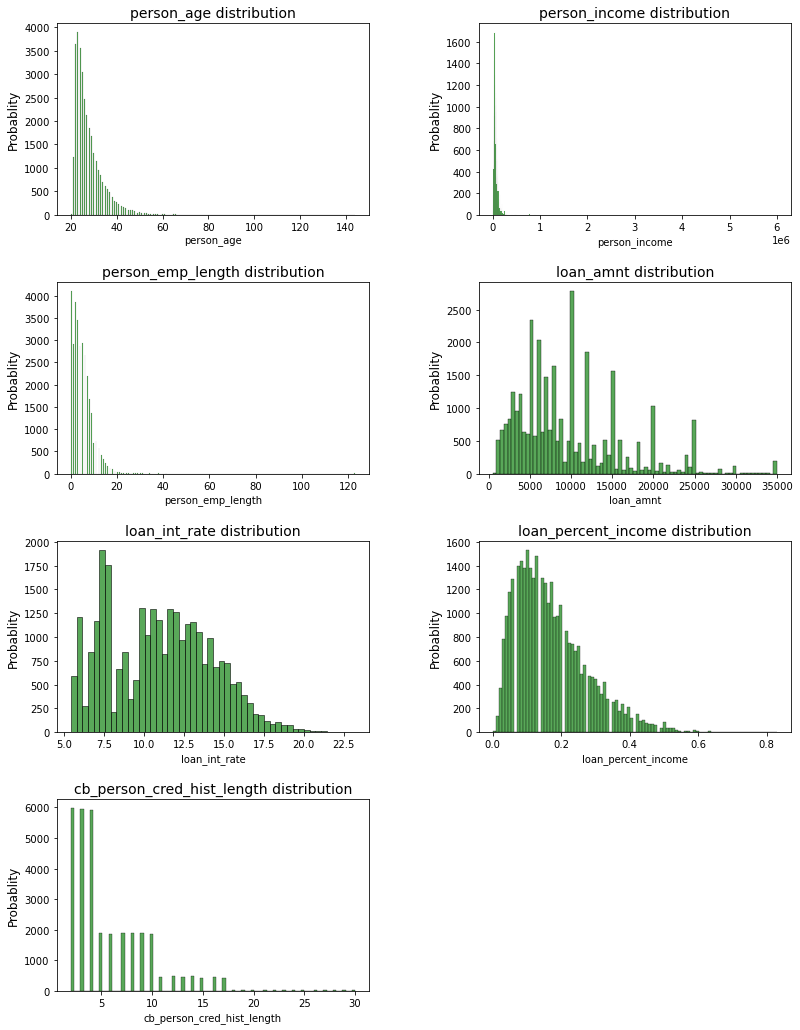

In [6]:
# drop the label column 'loan status' before visualization
num_cols_hist = num_cols.drop(['loan_status'], axis=1)
# visualize the distribution for each varieble
plt.figure(figsize=(12,16))

for i, col in enumerate(num_cols_hist.columns):
    idx = int('42'+ str(i+1))
    plt.subplot(idx)
    sns.histplot(num_cols_hist[col], color='forestgreen', 
                 kde_kws={'color': 'indianred', 'lw': 2, 'label': 'KDE'})
    plt.title(col+' distribution', fontsize=14)
    plt.ylabel('Probablity', fontsize=12)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)
plt.show()

In [7]:
# decribe the dataset
credit_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


**Observation:** All of the distributions are positive skewed.

* `person_age`: Most people are 20 to 60 years old. In the following analysis, to be more general, people age > 100 will be droped.
* `person_emp_length`: Most people have less than 40 years of employment. People with employment > 60 years will be droped.
* `person_income`: It seems that there are outliers which has to be removed (> 4 million).
* `person_emp_length` is the person employment history, to be more conservative, the nan values should be replaced with mode, which is 0 year.
* `loan_int_rate` is the loan income rate, to be more conservative, the nan values should be replaced with 10.99, which is the median
* For all other variables, the distribution is more uniform across the whole range, thus they will be kept.

In [8]:
# check the mode, median for the two features
print('person_emp_length mode {}'.format(credit_df['person_emp_length'].mode()[0]))
print('person_emp_length median {}'.format(credit_df['person_emp_length'].median()))
print('loan_int_rate mode {}'.format(credit_df['loan_int_rate'].mode()[0]))
print('loan_int_rate median {}'.format(credit_df['loan_int_rate'].median()))

person_emp_length mode 0.0
person_emp_length median 4.0
loan_int_rate mode 7.51
loan_int_rate median 10.99


In [9]:
# fill NaN with the mode
credit_df['person_emp_length'].fillna(credit_df['person_emp_length'].mode()[0], inplace=True)
credit_df['loan_int_rate'].fillna(credit_df['loan_int_rate'].median(), inplace=True)

In [10]:
# check the nans are replaced 
credit_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [11]:
# clean the dataset and drop outliers
cleaned_credit_df = credit_df[credit_df['person_age']<=100]
cleaned_credit_df = cleaned_credit_df[cleaned_credit_df['person_emp_length']<=60]
cleaned_credit_df = cleaned_credit_df[cleaned_credit_df['person_income']<=4e6]

In [12]:
default_df= cleaned_credit_df[cleaned_credit_df['loan_status']==1]
genuine_df= cleaned_credit_df[cleaned_credit_df['loan_status']==0]

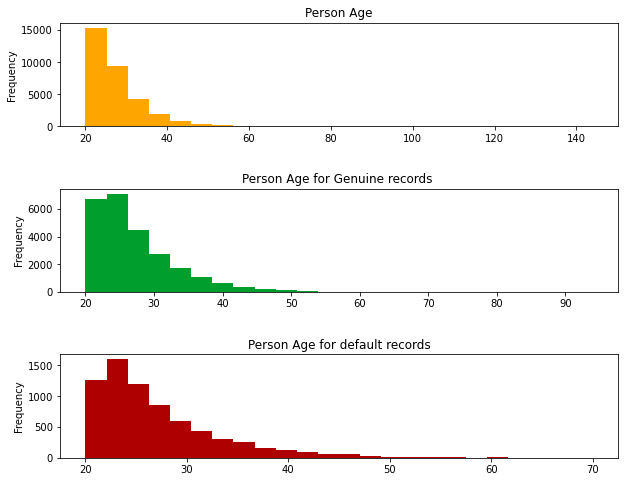

In [13]:
plt.figure(figsize=(10,8))

plt.subplot(3, 1, 1)
credit_df['person_age'].plot(kind='hist',  bins = 24, title="Person Age", color='orange') # ALL transactions

plt.subplot(3, 1, 2)
genuine_df["person_age"].plot(kind='hist', bins = 24, title="Person Age for Genuine records ", color = "#009e2d") # genuine

plt.subplot(3, 1, 3)
default_df["person_age"].plot(kind='hist', bins = 24,title="Person Age for default records", color = "#AF0000") # default
plt.subplots_adjust(hspace=0.6)

**Observation:** Lower the age, Higher the default. 

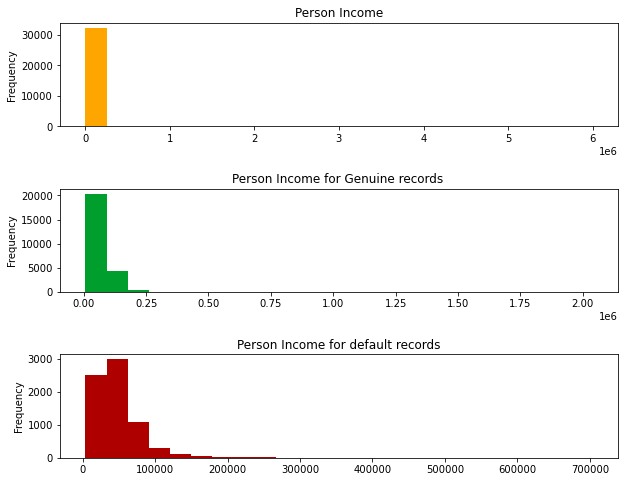

In [14]:
plt.figure(figsize=(10,8))

plt.subplot(3, 1, 1)
credit_df['person_income'].plot(kind='hist',  bins = 24, title="Person Income", color='orange') # ALL transactions

plt.subplot(3, 1, 2)
genuine_df["person_income"].plot(kind='hist', bins = 24, title="Person Income for Genuine records ", color = "#009e2d") # genuine

plt.subplot(3, 1, 3)
default_df["person_income"].plot(kind='hist', bins = 24,title="Person Income for default records", color = "#AF0000") # default
plt.subplots_adjust(hspace=0.6)

**Observation**: Lower the income, Higher the default.  

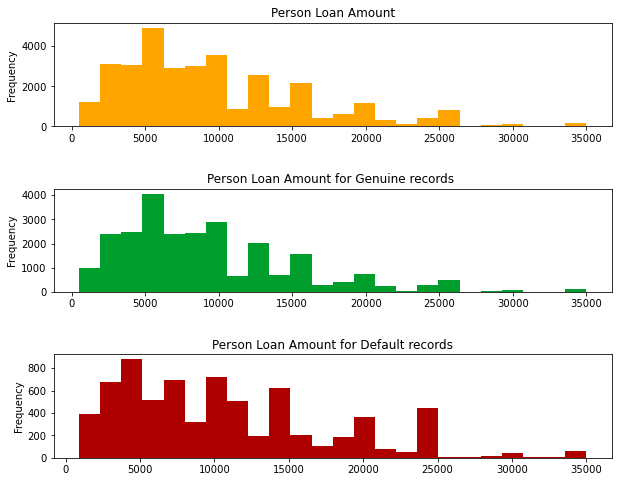

In [15]:
plt.figure(figsize=(10,8))

plt.subplot(3, 1, 1)
credit_df['loan_amnt'].plot(kind='hist',  bins = 24, title="Person Loan Amount", color='orange') # ALL transactions

plt.subplot(3, 1, 2)
genuine_df["loan_amnt"].plot(kind='hist', bins = 24, title="Person Loan Amount for Genuine records ", color = "#009e2d") # genuine

plt.subplot(3, 1, 3)
default_df["loan_amnt"].plot(kind='hist', bins = 24,title="Person Loan Amount for Default records", color = "#AF0000") # default
plt.subplots_adjust(hspace=0.6)

**Observation**: People with multiple loan amounts have committed default and have no clear relationship

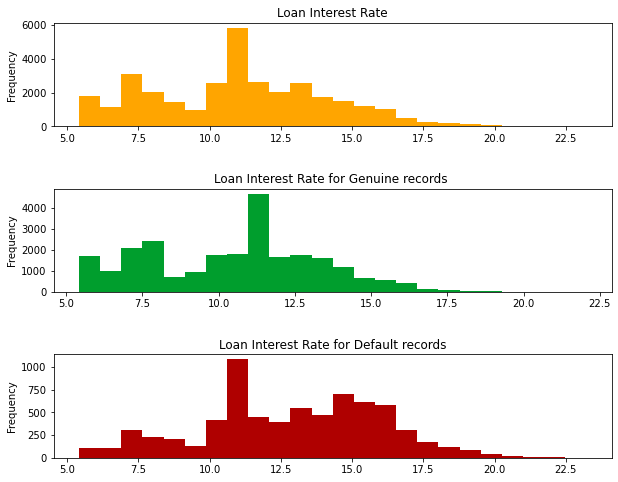

In [16]:
plt.figure(figsize=(10,8))

plt.subplot(3, 1, 1)
credit_df['loan_int_rate'].plot(kind='hist',  bins = 24, title="Loan Interest Rate", color='orange') # ALL transactions

plt.subplot(3, 1, 2)
genuine_df["loan_int_rate"].plot(kind='hist', bins = 24, title="Loan Interest Rate for Genuine records ", color = "#009e2d") # genuine

plt.subplot(3, 1, 3)
default_df["loan_int_rate"].plot(kind='hist', bins = 24,title="Loan Interest Rate for Default records", color = "#AF0000") # default
plt.subplots_adjust(hspace=0.6)

**Observation**: People tend to default higher when interest rates are high when compared to low. 

In [17]:
# get the cleaned numberical variebles
cleaned_num_cols = pd.DataFrame(cleaned_credit_df[cleaned_credit_df.select_dtypes(include=['float', 'int']).columns])

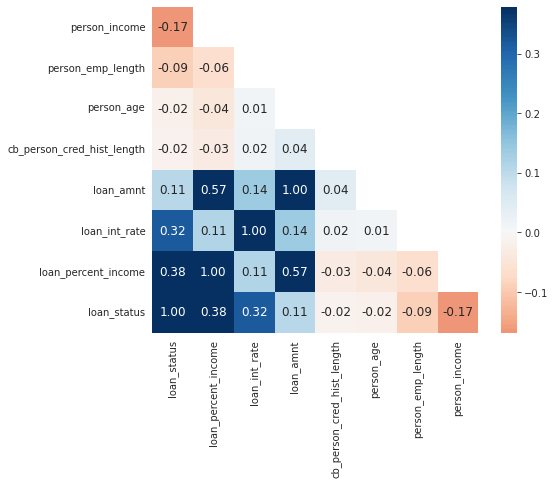

In [18]:
corr = cleaned_num_cols.corr().sort_values('loan_status', axis=1, ascending=False)
corr = corr.sort_values('loan_status', axis=0, ascending=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(corr, mask=mask, vmin=corr.loan_status.min(), 
                     vmax=corr.drop(['loan_status'], axis=0).loan_status.max(),
                     square=True, annot=True, fmt='.2f',
                     center=0, cmap='RdBu',annot_kws={"size": 12})

**Observation:** 

* `person_income`, `person_emp_length`, and `person_age`: has negative effect on loan_status being default, which means the larger these variebles, the less likely the person is risky.
* `loan_percent_income`, `loan_int_rate`, and `loan_amnt`: has postive effect on loan_status being default, which means the larger these variebles, the more likely the person is risky.

In [19]:
# get the categorical variebles 
cat_cols = pd.DataFrame(cleaned_credit_df[cleaned_credit_df.select_dtypes(include=['object']).columns])
cat_cols.columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

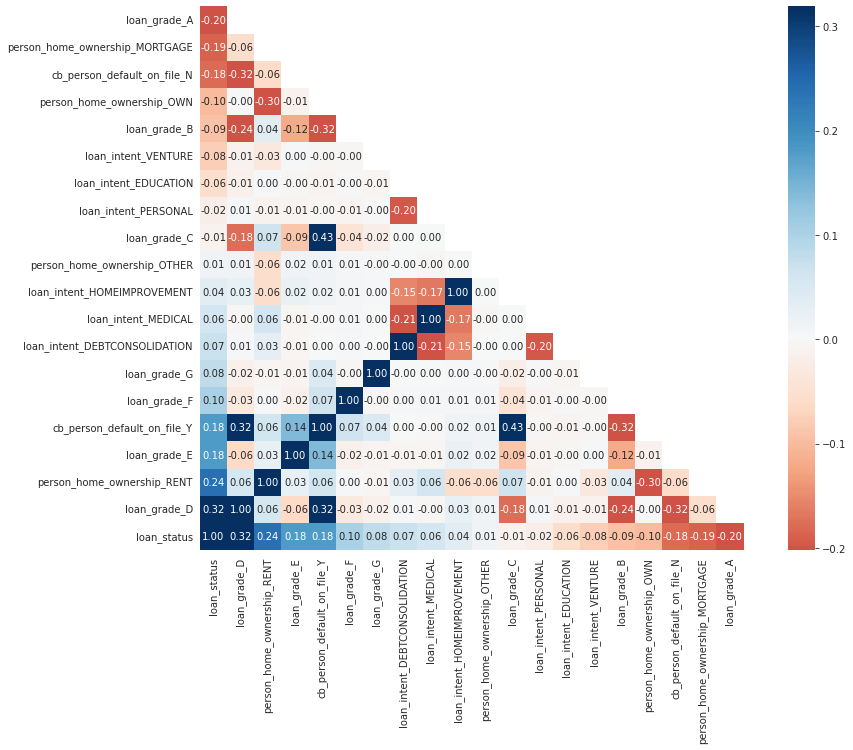

In [20]:
# one-hot encode the catogorical variebles
encoded_cat_cols = pd.get_dummies(cat_cols)
cat_cols_corr = pd.concat([encoded_cat_cols, cleaned_credit_df['loan_status']], axis=1)
corr = cat_cols_corr.corr().sort_values('loan_status', axis=1, ascending=False)
corr = corr.sort_values('loan_status', axis=0, ascending=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(corr, mask=mask, vmin=corr.loan_status.min(), 
                     vmax=corr.drop(['loan_status'], axis=0).loan_status.max(), 
                     square=True, annot=True, fmt='.2f',
                     center=0, cmap='RdBu',annot_kws={"size": 10})

In [21]:
# concat the numerical and one-hot encoded categorical variebles
cleaned_credit_df = pd.concat([cleaned_num_cols, encoded_cat_cols], axis=1)
cleaned_credit_df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,2,0,0,...,1,1,0,0,0,0,0,0,1,0


In [22]:
# check the cleaned dataset size 
print ('The cleaned dataset has {} rows and {} columns'.format(cleaned_credit_df.shape[0], 
                                                               cleaned_credit_df.shape[1]))
print ('The cleaned dataset has {} numerical features and {} categorical features'
       .format(len(cleaned_num_cols.columns)-1, len(encoded_cat_cols.columns)))

The cleaned dataset has 32574 rows and 27 columns
The cleaned dataset has 7 numerical features and 19 categorical features


## Modeling

In [23]:
# Split Train and Test Sets
label = cleaned_credit_df['loan_status'] # labels
features = cleaned_credit_df.drop('loan_status',axis=1) # features
x_train, x_test, y_train, y_test = model_selection.train_test_split(features, label, 
                                                                    random_state=42, test_size=.30)
print('The train dataset has {} data\nThe test dataset has {} data'.
      format(x_train.shape[0], x_test.shape[0]))


The train dataset has 22801 data
The test dataset has 9773 data


In [24]:
# define a model assess function to test a few model performance
def model_assess(model, name='Default'):
    '''
    This function is used to test model performance 
    
    Input: model, defined classifer
    Output: print the confusion matrix
    
    '''
    
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    preds_proba = model.predict_proba(x_test)
    print(name, '\n',classification_report(y_test, model.predict(x_test)))

### Evaluate different algorithms

In [25]:
#KNN
knn = KNeighborsClassifier(n_neighbors=50)
model_assess(knn, name='KNN')
#Logistic Regression
lg = LogisticRegression(random_state=42)
model_assess(lg, 'Logistic Regression')
# Dicision trees
D_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=42)
model_assess(D_tree, 'DecisionTree Classifier')
#XGB
xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=42) 
model_assess(xgb, 'XGBoost')

KNN 
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      7631
           1       0.74      0.41      0.53      2142

    accuracy                           0.84      9773
   macro avg       0.80      0.69      0.72      9773
weighted avg       0.83      0.84      0.82      9773

Logistic Regression 
               precision    recall  f1-score   support

           0       0.81      0.99      0.89      7631
           1       0.74      0.15      0.25      2142

    accuracy                           0.80      9773
   macro avg       0.77      0.57      0.57      9773
weighted avg       0.79      0.80      0.75      9773

DecisionTree Classifier 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      7631
           1       0.96      0.73      0.83      2142

    accuracy                           0.93      9773
   macro avg       0.94      0.86      0.89      9773
weighted avg       0

In [26]:
knn.score(x_test,y_test)

0.8394556430983321

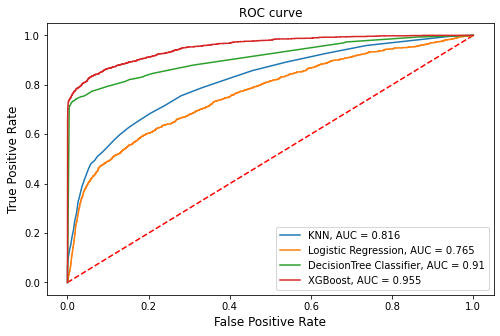

In [27]:
#ROC AUC
fig = plt.figure(figsize=(8,5))
plt.plot([0, 1], [0, 1],'r--')

#KNN
preds_proba_knn = knn.predict_proba(x_test)
probsknn = preds_proba_knn[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probsknn)
aucknn = roc_auc_score(y_test, probsknn)
plt.plot(fpr, tpr, label=f'KNN, AUC = {str(round(aucknn,3))}')

#Logistic Regression
preds_proba_lg = lg.predict_proba(x_test)
probslg = preds_proba_lg[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probslg)
auclg = roc_auc_score(y_test, probslg)
plt.plot(fpr, tpr, label=f'Logistic Regression, AUC = {str(round(auclg,3))}')

#DecisionTree Classifier
preds_proba_D_tree = D_tree.predict_proba(x_test)
probsD_tree = preds_proba_D_tree[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probsD_tree)
auclg = roc_auc_score(y_test, probsD_tree)
plt.plot(fpr, tpr, label=f'DecisionTree Classifier, AUC = {str(round(auclg,3))}')

#XGBoost
preds_proba_xgb = xgb.predict_proba(x_test)
probsxgb = preds_proba_xgb[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probsxgb)
aucxgb = roc_auc_score(y_test, probsxgb)
plt.plot(fpr, tpr, label=f'XGBoost, AUC = {str(round(aucxgb,3))}')
plt.ylabel("True Positive Rate", fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.title("ROC curve")
plt.rcParams['axes.titlesize'] = 16
plt.legend()
plt.show()

### Feature importance

In [28]:
feature_importance = pd.DataFrame({'feature': x_train.columns, 
                                   'importance': xgb.feature_importances_})

new_features_df = feature_importance[feature_importance['importance']>0
                                    ].sort_values(by=['importance'],ascending=False)

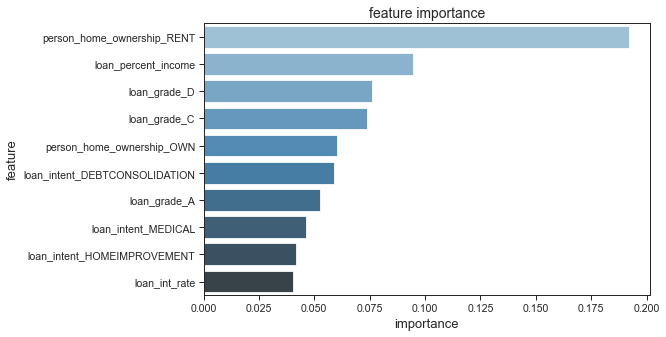

In [29]:
sns.set(context='paper', style='ticks',  font='sans-serif', 
        font_scale=1.2, color_codes=True, rc=None)
figure, ax = plt.subplots(figsize=(8, 5))
ax=sns.barplot(data = new_features_df[:10],
              y='feature',
              x='importance',
              palette='Blues_d') # rocket, Blues_d
ax.set_title('feature importance', fontsize=14)
ax.set_xlabel('importance', fontsize=13)
ax.set_ylabel('feature', fontsize=13)
plt.show()

In [30]:
# print the xgb base model
xgb

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

### Hyperparameter Tuning

In [31]:
# RandomizedSearchCV hyperparameter tuning
params = {
    "colsample_bytree": uniform(0.9, 0.1), # 0.9-1 0.9 is the lower bound, 0.1 is the range
    "gamma": uniform(0.2, 0.3),# 0.2-0.5
    "learning_rate": uniform(0.2, 0.2), # 0.2-0.4 
    "max_depth": randint(4, 6), # 4, 5, 6
    "n_estimators": randint(100, 300), # 100-300
    "subsample": uniform(0.9, 0.1) # 0.9-1
}

Random_CV = RandomizedSearchCV(xgb, param_distributions=params, random_state=42, 
                            n_iter=100, cv=3, verbose=2, n_jobs=16, return_train_score=True)

Random_CV.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_bin=256,...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E901845610>,
     

In [32]:
# function to return the top selcted models
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report_best_scores(Random_CV.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.934 (std: 0.002)
Parameters: {'colsample_bytree': 0.9094442960755929, 'gamma': 0.40490203202490704, 'learning_rate': 0.2142377296920458, 'max_depth': 5, 'n_estimators': 192, 'subsample': 0.9844875310969454}

Model with rank: 2
Mean validation score: 0.934 (std: 0.001)
Parameters: {'colsample_bytree': 0.9886680387298048, 'gamma': 0.2782680870025142, 'learning_rate': 0.20306090805807697, 'max_depth': 4, 'n_estimators': 285, 'subsample': 0.950103988391526}

Model with rank: 3
Mean validation score: 0.934 (std: 0.001)
Parameters: {'colsample_bytree': 0.9493025657771805, 'gamma': 0.2249853233585779, 'learning_rate': 0.21834082945169622, 'max_depth': 5, 'n_estimators': 124, 'subsample': 0.9553703052345801}



In [33]:
Random_best_xgb = Random_CV.best_estimator_
Random_best_xgb.fit(x_train, np.ravel(y_train)) 
preds_proba_Random = Random_best_xgb.predict_proba(x_test)
probs_Random = preds_proba_Random[:, 1]
Random_bestauc = roc_auc_score(y_test, probs_Random)
print ('xgb base model AUROC socre: {}'.format(aucxgb))
print ('xgb best model using RandomizedSearchCV AUROC socre: {}'.format(Random_bestauc))

xgb base model AUROC socre: 0.9547183395264366
xgb best model using RandomizedSearchCV AUROC socre: 0.955954023596072


In [34]:
# GridSearchCV hyperparameter tuning
params = {
    "colsample_bytree": [0.9, 0.91],
    "gamma": [0.45],
    "learning_rate": [0.26], # default 0.1 
    "max_depth": [5], # default 3
    "n_estimators": [150, 157, 160], # default 100
    "subsample": [0.98, 0.97, 0.96]
}

Grid_CV = GridSearchCV(xgb, param_grid=params, cv=3, verbose=1, n_jobs=16, return_train_score=True)
Grid_CV.fit(x_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_ca...
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parall

In [35]:
report_best_scores(Grid_CV.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.935 (std: 0.002)
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.45, 'learning_rate': 0.26, 'max_depth': 5, 'n_estimators': 157, 'subsample': 0.97}

Model with rank: 1
Mean validation score: 0.935 (std: 0.002)
Parameters: {'colsample_bytree': 0.91, 'gamma': 0.45, 'learning_rate': 0.26, 'max_depth': 5, 'n_estimators': 157, 'subsample': 0.97}

Model with rank: 3
Mean validation score: 0.935 (std: 0.002)
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.45, 'learning_rate': 0.26, 'max_depth': 5, 'n_estimators': 160, 'subsample': 0.97}

Model with rank: 3
Mean validation score: 0.935 (std: 0.002)
Parameters: {'colsample_bytree': 0.91, 'gamma': 0.45, 'learning_rate': 0.26, 'max_depth': 5, 'n_estimators': 160, 'subsample': 0.97}



In [36]:
Grid_best_xgb = Grid_CV.best_estimator_
Grid_best_xgb.fit(x_train, np.ravel(y_train)) 
preds_proba_Grid = Grid_best_xgb.predict_proba(x_test)
probs_Grid = preds_proba_Grid[:, 1]
Grid_bestauc = roc_auc_score(y_test, probs_Grid)
print ('xgb base model AUROC socre: {}'.format(aucxgb))
print ('xgb best model using RandomizedSearchCV AUROC socre: {}'.format(Random_bestauc))
print ('xgb best model using GridSearchCV AUROC socre: {}'.format(Grid_bestauc))

xgb base model AUROC socre: 0.9547183395264366
xgb best model using RandomizedSearchCV AUROC socre: 0.955954023596072
xgb best model using GridSearchCV AUROC socre: 0.9557357997582469


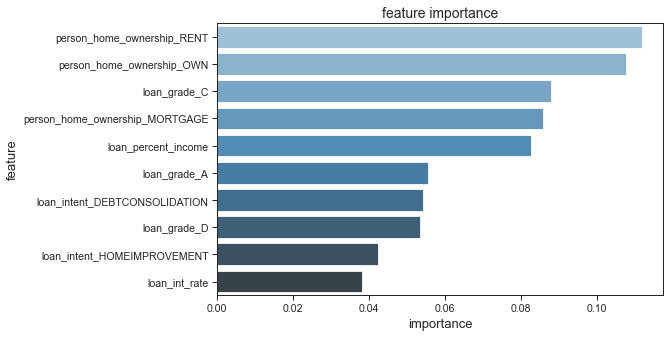

In [37]:
# display feature and their importance of the best model
feature_importance = pd.DataFrame({'feature': x_train.columns, 
                                   'importance': Grid_best_xgb.feature_importances_})

new_features_df = feature_importance[feature_importance['importance']>0
                                    ].sort_values(by=['importance'],ascending=False)

sns.set(context='paper', style='ticks',  font='sans-serif', 
        font_scale=1.2, color_codes=True, rc=None)
figure, ax = plt.subplots(figsize=(8, 5))
ax=sns.barplot(data = new_features_df[:10],
              y='feature',
              x='importance',
              palette='Blues_d') # rocket, Blues_d
ax.set_title('feature importance', fontsize=14)
ax.set_xlabel('importance', fontsize=13)
ax.set_ylabel('feature', fontsize=13)
plt.show()


In [38]:
# display the top 10 important features
new_features_df.head(10)

,feature,importance
10,person_home_ownership_RENT,0.111887
9,person_home_ownership_OWN,0.107743
19,loan_grade_C,0.087880
7,person_home_ownership_MORTGAGE,0.085841
5,loan_percent_income,0.082684
17,loan_grade_A,0.055413
11,loan_intent_DEBTCONSOLIDATION,0.054122
20,loan_grade_D,0.053492
13,loan_intent_HOMEIMPROVEMENT,0.042287
4,loan_int_rate,0.038289


**Observation**

The top 5 important features includes:
* `person_home_ownership_RENT`
* `person_home_ownership_OWN`
* `loan_grade_C`
* `loan_percent_income`
* `person_home_ownership_MORTGAGE`

In [39]:
# select the top 20 features and then retrain the model
new_features = new_features_df['feature'][0:20]
new_features

10        person_home_ownership_RENT
9          person_home_ownership_OWN
19                      loan_grade_C
7     person_home_ownership_MORTGAGE
5                loan_percent_income
17                      loan_grade_A
11     loan_intent_DEBTCONSOLIDATION
20                      loan_grade_D
13       loan_intent_HOMEIMPROVEMENT
4                      loan_int_rate
14               loan_intent_MEDICAL
16               loan_intent_VENTURE
23                      loan_grade_G
18                      loan_grade_B
1                      person_income
21                      loan_grade_E
22                      loan_grade_F
2                  person_emp_length
24       cb_person_default_on_file_N
0                         person_age
Name: feature, dtype: object

In [40]:
# Split Train and Test Sets
new_features_df = pd.DataFrame(cleaned_credit_df[new_features])
new_features_df.shape

(32574, 20)

In [41]:
x_train1, x_test1, y_train1, y_test1 = model_selection.train_test_split(new_features_df, label, 
                                                                    random_state=42, test_size=.30)
print('The train dataset has {} data\nThe test dataset has {} data'.
      format(x_train.shape[0], x_test.shape[0]))

The train dataset has 22801 data
The test dataset has 9773 data


In [42]:
# RandomizedSearchCV hyperparameter tuning
params = {
    "colsample_bytree": uniform(0.9, 0.1), # 0.9-1 0.9 is the lower bound, 0.1 is the range
    "gamma": uniform(0.2, 0.3),# 0.2-0.5
    "learning_rate": uniform(0.2, 0.2), # 0.2-0.4 
    "max_depth": randint(4, 6), # 4, 5, 6
    "n_estimators": randint(100, 300), # 100-300
    "subsample": uniform(0.9, 0.1) # 0.9-1
}

Random_CV = RandomizedSearchCV(xgb, param_distributions=params, random_state=42, 
                            n_iter=100, cv=3, verbose=2, n_jobs=16, return_train_score=True)

Random_CV.fit(x_train1, y_train1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_bin=256,...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E903389700>,
     

In [43]:
report_best_scores(Random_CV.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.935 (std: 0.002)
Parameters: {'colsample_bytree': 0.9986001063822871, 'gamma': 0.4260134555776825, 'learning_rate': 0.2752519171061832, 'max_depth': 4, 'n_estimators': 118, 'subsample': 0.9777146915927437}

Model with rank: 2
Mean validation score: 0.934 (std: 0.001)
Parameters: {'colsample_bytree': 0.9556005038642584, 'gamma': 0.2968059164832751, 'learning_rate': 0.20868015665963457, 'max_depth': 4, 'n_estimators': 263, 'subsample': 0.9553854284401321}

Model with rank: 3
Mean validation score: 0.934 (std: 0.001)
Parameters: {'colsample_bytree': 0.968030753858778, 'gamma': 0.3351497755908629, 'learning_rate': 0.2026529922319733, 'max_depth': 4, 'n_estimators': 159, 'subsample': 0.9563288217845539}



In [45]:
Random_best_xgb = Random_CV.best_estimator_
Random_best_xgb.fit(x_train1, np.ravel(y_train1)) 
preds_proba_Random = Random_best_xgb.predict_proba(x_test1)
probs_Random = preds_proba_Random[:, 1]
Random_bestauc = roc_auc_score(y_test1, probs_Random)
print ('xgb base model AUROC socre: {}'.format(aucxgb))
print ('xgb best model using RandomizedSearchCV AUROC socre: {}'.format(Random_bestauc))

xgb base model AUROC socre: 0.9547183395264366
xgb best model using RandomizedSearchCV AUROC socre: 0.9536975756536835


**Observation**

it turns out after dropping some features, the model is only improved to 0.955, thus no furhter GridSearchCV is performed. And the original GridSearchCV best model will be used for futher threshhold optimizaiton. 

### Threshold Optimization

In [46]:
preds = Grid_best_xgb.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

pred_probs = pd.DataFrame(preds[:,1],columns = ['Default Probability'])

pd.concat([pred_probs, y_test.reset_index(drop=True)],axis=1)
thresh = np.linspace(0,1,41)
thresh

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   ])

In [47]:
def optimize_threshold(predict,thresholds =thresh, y_true = y_test):
    data = predict
    
    def_recalls = []
    nondef_recalls = []
    accs =[]

    
    for threshold in thresholds:
        # predicted values for each threshold
        data['loan_status'] = data['Default Probability'].apply(lambda x: 1 if x > threshold else 0 )
        
        accs.append(metrics.accuracy_score(y_true, data['loan_status']))
        
        stats = metrics.precision_recall_fscore_support(y_true, data['loan_status'], zero_division=0)
        
        def_recalls.append(stats[1][1])
        nondef_recalls.append(stats[1][0])
        
        
    return accs, def_recalls, nondef_recalls

accs, def_recalls, nondef_recalls = optimize_threshold(pred_probs)


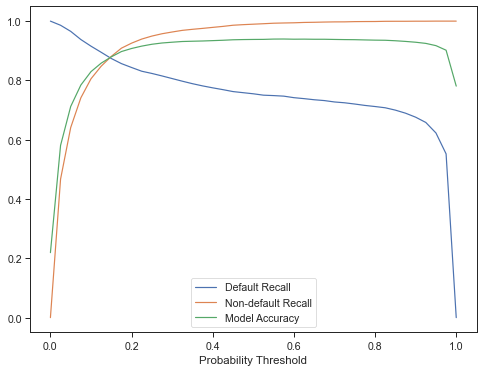

In [48]:
figure = plt.subplots(figsize=(8, 6))
plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

In [49]:
optim_threshold = accs.index(max(accs))

print('The model accuracy is {} using the optimal probabilty threshold'
      .format(round(accs[optim_threshold],3)))

print ('The optimal probabilty threshold is {}'.format(thresh[optim_threshold]))

The model accuracy is 0.94 using the optimal probabilty threshold
The optimal probabilty threshold is 0.5750000000000001


** Discussion**

* The XGBClassifier has the best performance with 0.954 AUROC score compared to other three classifiers KNN, Logistic regression, and decision tree using the base model.

* Using RandomizedSearchCV to fast optimize hyperparamters, the model AUROC is improved to 0.9563

* With further fine tuning around those hyperparameters using GridSearchCV, the final best model has a 0.9571 AUROC score. 

* The optimal probability threshold for the best model is 0.55 resulting accuracy 0.939.

